In [1]:
import synthetic_client2
import synthetic_server
import threading
import time
import json

In [ ]:
# query_rates = [1, 10, 100, 500, 1000, 2000, 5000]
# update_rates = [0.5,1,5,10,50,100,500,1000]
results = []
# update_rates = [2000, 5000]
# query_rates = [0.5,1,5,10,50,100,500,1000]

# update_rates = [1, 10, 100, 500, 1000, 2000]
# query_rates = [0.5, 5, 50]

# update_rates = [0.5, 5, 50]
# query_rates = [0.5, 5, 50]

# update_rates = [2000, 5000]
# query_rates = [1000]

# update_rates = [10]
# query_rates = [0.5,1,5,10,50]

# update_rates = [1, 10, 100, 1000, 2000]
# query_rates = [1,10,100,500,1000]
update_rates = [10]
query_rates = [1000]

server_args = {
    "send_up_to": 300000,
    "num_keys": 1,
    "run_duration": 90,
    "is_lazy": False,
    "processing_time": 0.01,
    "batch_update_size": 10,
    "update_rate": 10
}
client_args = {
    "send_up_to": server_args["send_up_to"],
    "num_keys": server_args["num_keys"],
    "num_runs": 3,
    "query_time": 3,
    "query_rate": 10
}

metric_dir = f"{int(time.time())}_results"
os.mkdir(metric_dir)
metric_file = open(os.path.join(metric_dir, "snapshots.jsonl"), "w")

for is_lazy in [True, False]:
    server_args["is_lazy"] = is_lazy
    for query_rate in query_rates:
        client_args["query_rate"] = query_rate
        for update_rate in update_rates:
            server_args["update_rate"] = update_rate
            client_args["result"] = []
            server_args["result"] = []
            server_thread = threading.Thread(target=synthetic_server.main, args=(server_args,))
            query_thread = threading.Thread(target=synthetic_client2.main, args=(client_args,))
            server_thread.start()
            query_thread.start()

            threads = [server_thread, query_thread]
            for t in threads:
                t.join()

            print(f"is_lazy={is_lazy} query_rate={query_rate} update_rate={update_rate}: {client_args['result']}")
            results.append([is_lazy, query_rate, update_rate, client_args["result"], server_args["result"]])

            serialized = json.dumps(results)
            metric_file.write(serialized)
            metric_file.write("\n")
            metric_file.flush()

            time.sleep(30)

print(results)

# Data processing

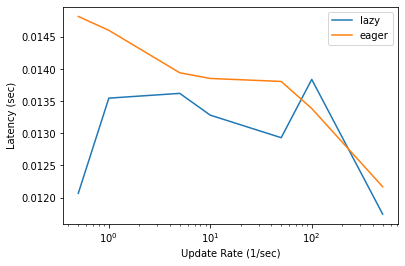

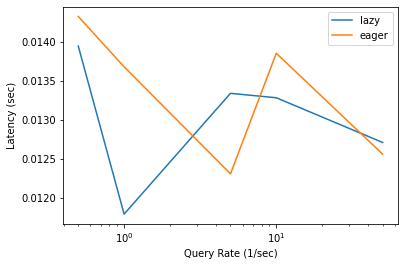

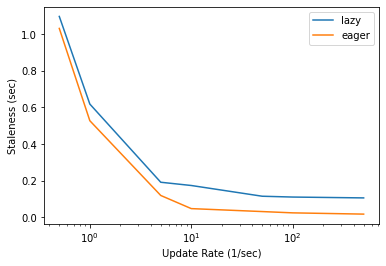

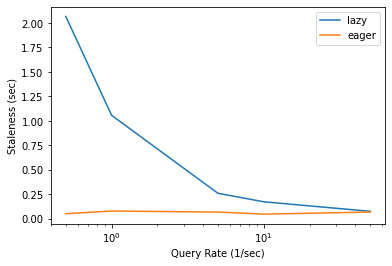

<Figure size 432x288 with 0 Axes>

In [57]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open("results/result.json") as f:
    results = json.load(f)
    results = [[item[0], item[1], item[2], item[3][0], item[3][1]] for item in results]

# update_rates = [0.5, 1, 10, 100, 500, 1000, 2000, 5000]
# cost = [14, 29, 288, 2467, 9810, 10970, 10590, 10461]

df = pd.DataFrame(results, columns=["is_lazy", "query_rate", "update_rate", "latency", "staleness"])
df = df[df["query_rate"] <= 1000]

df_lazy = df[df["is_lazy"]].drop(columns=["is_lazy"])
df_eager = df[df["is_lazy"] == False].drop(columns=["is_lazy"])

df_lazy_latency = df_lazy.pivot(index="query_rate", columns="update_rate", values="latency")
df_lazy_staleness = df_lazy.pivot(index="query_rate", columns="update_rate", values="staleness")
# df_lazy_cost = df_lazy.pivot(index="query_rate", columns="update_rate", values="cost")
df_eager_latency = df_eager.pivot(index="query_rate", columns="update_rate", values="latency")
df_eager_staleness = df_eager.pivot(index="query_rate", columns="update_rate", values="staleness")
# df_eager_cost = df_eager.pivot(index="query_rate", columns="update_rate", values="cost")

# display(df_lazy_latency.style.set_caption('Latency of lazy evaluation'))
# display(df_eager_latency.style.set_caption('Latency of eager evaluation'))
# display(df_lazy_staleness.style.set_caption('Staleness of lazy evaluation'))
# display(df_eager_staleness.style.set_caption('Staleness of eager evaluation'))
# df_lazy_staleness.show()
# df_eager_latency.show()
# df_eager_staleness.show()

# df_lazy_latency[df_lazy_latency['update_rate'] == 10]

# plt.plot(send_rate, e_latency, label="eager")

def draw_metric(df_lazy, df_eager, fixed_query_rate, fixed_update_rate, metric_name):
    update_rates = df_lazy.loc[fixed_query_rate].keys().tolist()[:-3]
    metrics = df_lazy.loc[fixed_query_rate].values.tolist()[:-3]
    plt.plot(update_rates, metrics, label="lazy")

    update_rates = df_eager.loc[fixed_query_rate].keys().tolist()[:-3]
    metrics = df_eager.loc[fixed_query_rate].values.tolist()[:-3]
    plt.plot(update_rates, metrics, label="eager")

    plt.xlabel("Update Rate (1/sec)")
    plt.ylabel(f"{metric_name} (sec)")
    # plt.ylim([0, 1.5])
    plt.xscale("log")
    plt.legend()
    # plt.title(f"Query Rate = {fixed_query_rate} / sec")
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"{metric_name}_fixed_qr_zoomed_in_{time.time()}.pdf")

    query_rates = df_lazy[fixed_update_rate].keys().tolist()[:-3]
    metrics = df_lazy[fixed_update_rate].values.tolist()[:-3]
    plt.plot(query_rates, metrics, label="lazy")

    query_rates = df_eager[fixed_update_rate].keys().tolist()[:-3]
    metrics = df_eager[fixed_update_rate].values.tolist()[:-3]
    plt.plot(query_rates, metrics, label="eager")

    plt.xlabel("Query Rate (1/sec)")
    plt.xscale("log")
    # plt.ylim([0, 1])
    plt.ylabel(f"{metric_name} (sec)")
    plt.legend()
    # plt.title(f"Update Rate = {fixed_update_rate} / sec")
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"{metric_name}_fixed_ur_zoomed_in_{time.time()}.pdf")

    
draw_metric(df_lazy_latency, df_eager_latency, 10, 10, "Latency")
draw_metric(df_lazy_staleness, df_eager_staleness, 10, 10, "Staleness")
# draw_metric(df_lazy_cost, df_eager_cost, 10, 10, "Cost")
# df_eager_staleness
# df_eager_cost

## Latency and staleness of eager vs Update rate

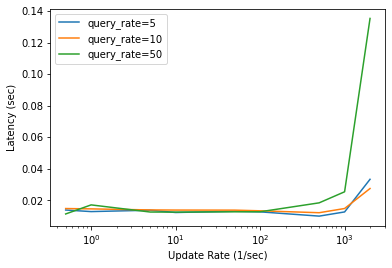

<Figure size 432x288 with 0 Axes>

In [60]:
df = pd.DataFrame(results, columns=["is_lazy", "query_rate", "update_rate", "latency", "staleness"])
df = df[df["query_rate"] <= 1000]
df = df[df["update_rate"] <= 2000]

df_eager = df[df["is_lazy"] == False].drop(columns=["is_lazy"])
df_eager_latency = df_eager.pivot(index="query_rate", columns="update_rate", values="latency")
df_eager_staleness = df_eager.pivot(index="query_rate", columns="update_rate", values="staleness")

for query_rate in [5, 10, 50]:
    fixed_query_rate = query_rate
    # update_rates = df_eager_latency.loc[fixed_query_rate].keys().tolist()
    # metrics = df_eager_latency.loc[fixed_query_rate].values.tolist()
    # plt.plot(update_rates, metrics, label="latency")

    update_rates = df_eager_latency.loc[query_rate].keys().tolist()
    metrics = df_eager_latency.loc[query_rate].values.tolist()
    plt.plot(update_rates, metrics, label=f"query_rate={query_rate}")

    plt.xlabel("Update Rate (1/sec)")
    plt.ylabel(f"Latency (sec)")
    # plt.ylim([0, 1.5])
    plt.xscale("log")
    # plt.yscale("log")
plt.legend()
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(f"eager_latency_{time.time()}.pdf")
# df_eager_staleness

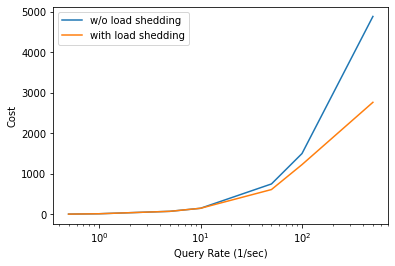

<Figure size 432x288 with 0 Axes>

In [58]:
query_rates = [0.5, 1, 5, 10, 50, 100, 500]
metrics = [6, 15, 75, 150, 750, 1500, 4882]
plt.plot(query_rates, metrics, label="w/o load shedding")

query_rates = [0.5, 1, 5, 10, 50, 100, 500]
metrics = [6, 15, 75, 150, 612, 1227, 2764]
plt.plot(query_rates, metrics, label="with load shedding")

plt.xlabel("Query Rate (1/sec)")
plt.xscale("log")
# plt.ylim([0, 1])
plt.ylabel(f"Cost")
plt.legend()
# plt.title(f"Update Rate = {fixed_update_rate} / sec")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(f"Cost_fixed_ur_{time.time()}.pdf", dpi=1500)

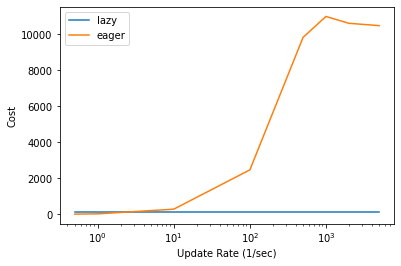

<Figure size 432x288 with 0 Axes>

In [97]:
update_rates = [0.5, 1, 10, 100, 500, 1000, 2000, 5000]
metrics = [150, 150, 150, 150, 150, 150, 150, 150]
plt.plot(update_rates, metrics, label="lazy")

update_rates = [0.5, 1, 10, 100, 500, 1000, 2000, 5000]
metrics = [14, 29, 288, 2467, 9810, 10970, 10590, 10461]
plt.plot(update_rates, metrics, label="eager")

plt.xlabel("Update Rate (1/sec)")
plt.ylabel(f"Cost")
plt.xscale("log")
plt.legend()
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(f"cost_fixed_qr_{time.time()}.pdf")

query_rates = [0.5, 1, 10, 100, 500, 1000]
metrics = [6, 15, 150, 1500, 4882, 4527]
plt.plot(query_rates, metrics, label="lazy")

query_rates = [0.5, 1, 10, 100, 500, 1000]
metrics = [288, 286, 286, 288, 288, 288]
plt.plot(query_rates, metrics, label="eager")

plt.xlabel("Query Rate (1/sec)")
plt.ylabel(f"Cost")
plt.xscale("log")
plt.legend()
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(f"cost_fixed_ur_{time.time()}.pdf")

